In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Style graphique utilisé pour les visualisations
plt.style.use('ggplot')

In [3]:
#Importation fichier source
df_7 =pd.read_csv(r"C:\Users\elodi\Documents\DATA\Data Analyst\Projets\P7\df_7.csv")
df_7.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


#### Coefficient d'élasticité

In [4]:
#elasticity = pd.read_csv(r"C:\Users\elodi\Downloads\projet_7\elasticity.txt", sep = "\t")[:16]
elasticity = pd.read_csv(r"C:\Users\elodi\Downloads\projet_7\elasticity.txt", 
            skiprows=3, skipfooter=17, skipinitialspace=True, 
            sep="|", decimal=".", 
            engine="python").dropna()
elasticity = elasticity.rename(columns={"Unnamed: 0":"region",
                                        "Base case":"base_case",
                                        "Optimistic":"high_mobility",
                                        "Pessimistic":"low_mobility"})
elasticity

,region,Base case,Optimistic,low_mobility
2,Nordic European countries,0.20,0.15,0.3
5,Europe (except nordic,0.40,0.3,0.5
8,Australia/New Zealand/USA,0.40,0.3,0.5
10,Asia,0.50,0.4,0.6
12,Latin America/Africa,0.66,0.5,0.9


In [5]:
#Chargement et traitement des données GDIM
gdim = pd.read_csv(r"C:\Users\elodi\Downloads\GDIMMay2018+(1).csv").loc[:, ['countryname', 'iso3', 'region', 'IGEincome']]
gdim.rename(columns={'countryname': 'country', 'iso3' : 'country_code'}, inplace=True)
gdim.drop_duplicates(inplace=True)
gdim.drop_duplicates(subset=['country'], keep = 'last', inplace=True)
display(gdim.head(10))
display(gdim.shape)

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
183,Australia,AUS,High income,0.275000
243,Austria,AUT,High income,0.245267
279,Azerbaijan,AZE,Europe & Central Asia,NaN
351,Belgium,BEL,High income,0.183176
405,Benin,BEN,Sub-Saharan Africa,0.855116


(150, 4)

In [6]:
#Isolement des pays sans valeur pour la variable 'IGEincome'
missing_gdim = gdim[gdim['IGEincome'].isna()]
display(missing_gdim.tail())
display(len(missing_gdim))

,country,country_code,region,IGEincome
6298,"Venezuela, RB",VEN,Latin America & Caribbean,NaN
6366,Vanuatu,VUT,East Asia & Pacific,NaN
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6492,Zambia,ZMB,Sub-Saharan Africa,NaN


77

In [7]:
#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = missing_gdim['country_code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
#Visualisation des régions concernées 
list(missing_gdim.region.unique())

['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

In [8]:
#Visualisation des pays concernés par la région 'High income'
missing_gdim[missing_gdim['region'] == 'High income']['country'].unique()

array(['Estonia', 'Hungary', 'Iceland', 'Israel', 'Lithuania', 'Poland',
       'Uruguay'], dtype=object)

In [9]:
#Boucle itérative afin d'imputer les valeurs NaN sur la variable 'IGEincome'
for code in missing_countries_gdim :
    if list(gdim.loc[gdim['country_code'] == code, 'region']) == ['South Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Sub-Saharan Africa']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Latin America & Caribbean']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Europe & Central Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.40                                                               
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['East Asia & Pacific']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    else : gdim.loc[gdim['country_code'] == code, 'IGEincome'] =  0.40 

In [10]:
#Jointure avec le df_7
#'IGEincome' sera renommé en 'pj'
df_income_mobility = pd.merge(df_7, gdim[['country_code', 'IGEincome']], how='left', on='country_code')
df_income_mobility.rename(columns={'IGEincome': 'pj'}, inplace=True)
df_income_mobility.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


In [11]:
list_missing_countries = list(df_income_mobility[df_income_mobility['pj'].isna()]['country'].unique())
list_missing_countries

['Kosovo', 'Syrian Arab Republic']

La Syrie est un pays d'Asie de l'Ouest > pj = 0.50 et le Kosovo est un pays d'Europe du Sud > pj = 0.40

In [12]:
for country in list_missing_countries :
    if list(df_income_mobility[df_income_mobility['country'] == "Kosovo"]):
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.40
    else : 
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.50

In [13]:
#Vérification des valeurs nulles
df_income_mobility.isna().any()

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
avg_income      False
pj              False
dtype: bool

In [14]:
#Visualisation des premières lignes de l'échantillon 
display(df_income_mobility.head())
display(df_income_mobility.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


(11600, 11)

L'échantillon contient 11600 individus, notre échantillon de travail a désormais son coefficient d'élasticité qui mesure la mobilité intergénérationnelle du revenu. A partir des 3 variables explicatives le revenu moyen du pays, l'indice de Gini du pays et le coefficient d'élasticité, nous pourrons générer des classes de revenu des parents.

#### 1. Revenus des parents selon une loi normale (de moyenne 0 et d'écart-type 1)
Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons  \(ln(Y_{parent})\) selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.

In [15]:
pj = 0.33                #Coefficient d'élasticité d'un pays j (ici la France sera prise pour exemple)
nb_quantiles = 100       #Nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles    #Taille de l'échantillon

In [16]:
#Utilisation de scipy pour générer aléatoirement la variable 'ln(Yparent)'
ln_y_parent = st.norm(0,1).rvs(size=n)

#### 2. Terme d'erreur ϵ selon une loi normale (de moyenne 0 et d'écart-type 1)
Générez \(n\) réalisations du terme d'erreur \(\epsilon\) selon une loi normale de moyenne 0 et d'écart type 1

In [17]:
#Utilisation de scipy pour générer aléatoirement epsilon
residues = st.norm(0,1).rvs(size=n)

#### 3. Revenus des enfants ychild
Pour une valeur donnée de \(\rho_j\) (par exemple 0.9), calculez \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . Le choix de \( \alpha\) n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, \(y_{child}\) contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [18]:
#Génération des revenus des parents et des enfants selon les éléments cités ci-dessus
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

y_child, y_parents = generate_incomes(n, pj)

#### 4. Calcul des classes de revenu des enfants et des parents selon les n individus générés précédemment
Pour chacun des n individus générés, les classes de revenu sont calculées selon ychild et yparent.

In [19]:
#Création d'un échantillon nommé "sample" via deux fonctions répondant aux critères liés aux quantiles
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [20]:
display(sample.head())

,y_child,y_parents,c_i_child,c_i_parent
0,0.223686,1.006371,8,51
1,0.786013,1.142417,42,56
2,1.803865,1.081101,72,54
3,1.534924,1.649441,67,70
4,1.492995,0.558149,66,29


#### 5. Estimation de la distribution conditionnelle des classes de revenus parents pour chaque classe enfant
Les calculs sont toujours dépendants du coefficient d'élasticité pj du pays, dans notre cas d'exemple nous sommes toujours en pj = 0.33 pour la France.

In [21]:
#utilisation des fonctions de distribution et de probabilité conditionnelles
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]


cd = conditional_distributions(sample, nb_quantiles)

In [22]:
#Itération selon nos classes de revenu
nb_quantiles = 101
cd = conditional_distributions(sample, nb_quantiles)

class myInformativeException(Exception):
    def __init__(self, count):
        self.count = count
proba = []
try:        
    for x, y in zip(sample['c_i_child'], sample['c_i_parent']):
        p = proba_cond(y, x, cd)
        proba.append(p)
except myInformativeException as e:
    print("Error on ", e.count)

sample['proba'] = proba
sample.head()

,y_child,y_parents,c_i_child,c_i_parent,proba
0,0.223686,1.006371,8,51,0.013
1,0.786013,1.142417,42,56,0.012
2,1.803865,1.081101,72,54,0.012
3,1.534924,1.649441,67,70,0.016
4,1.492995,0.558149,66,29,0.004


#### 6.Visualisation des distributions conditionnelles
A des fins de vérification, nous pouvons créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9)

In [23]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_high(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Forte mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.show()

#### Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj 

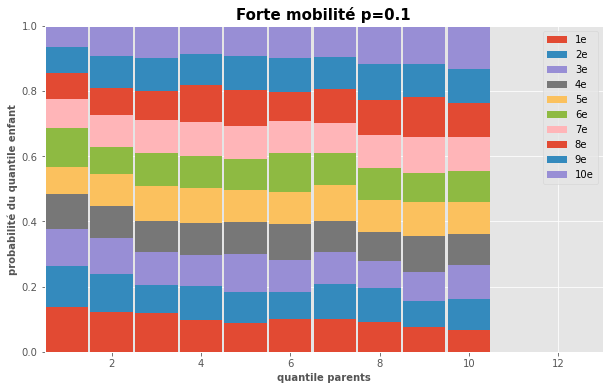

In [24]:
#Exemple d'une forte mobilité avec un pj = 0.1
pj_strong = 0.1                
nb_quantiles_strong = 10       
n_strong  = 1000*nb_quantiles_strong   

y_child_strong, y_parents_strong = generate_incomes(n_strong, pj_strong)
sample_strong = compute_quantiles(y_child_strong, y_parents_strong, nb_quantiles_strong)
cd_strong = conditional_distributions(sample_strong, nb_quantiles_strong)
plot_conditional_distributions_high(pj_strong, cd_strong, nb_quantiles_strong)

In [25]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_low(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Faible mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.show()

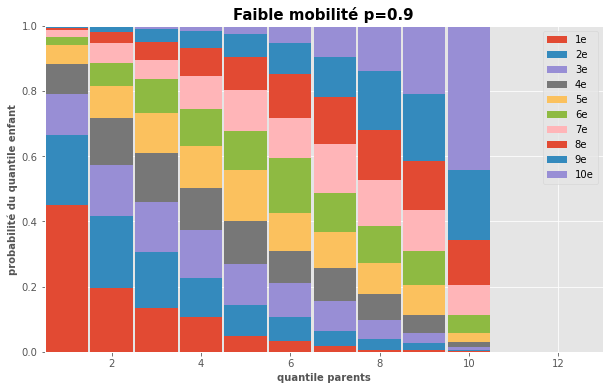

In [26]:
#Exemple d'une très faible mobilité avec un pj = 0.9
pj_low = 0.9                
nb_quantiles_low = 10       
n_low  = 1000*nb_quantiles_low   

y_child_low, y_parents_low = generate_incomes(n_low, pj_low)
sample_low = compute_quantiles(y_child_low, y_parents_low, nb_quantiles_low)
cd_low = conditional_distributions(sample_low, nb_quantiles_low)
plot_conditional_distributions_low(pj_low, cd_low, nb_quantiles_low)

#### 7.Suppression des individus
Pour éviter toute confusion, les individus générés sont supprimés (car inutiles pour la suite), seules les distributions conditionnelles sont conservées.

In [27]:
sample = sample.iloc[:, 2:]
sample

,c_i_child,c_i_parent,proba
0,8,51,0.013
1,42,56,0.012
2,72,54,0.012
3,67,70,0.016
4,66,29,0.004
...,...,...,...
99995,16,12,0.014
99996,24,85,0.005
99997,55,72,0.013
99998,72,67,0.014


#### 8. Nouvel échantillon : 500 fois plus grande que celui de la World Income Distribution
Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, il y aura 499 "clones". La taille du nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.

In [28]:
wid_500 = pd.concat([df_income_mobility]*500).reset_index().drop('index', axis=1)
wid_500.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


#### 9.Attribution des classes parents aux 500 individus de chaque pays
Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.

In [29]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(wid_500) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

In [30]:
wid_500 = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    wid_500], axis=1)
wid_500

,ln_y_parent,residus,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income,pj
0,-1.003958,0.065263,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30,2994.829902,0.815874
1,2.009045,-2.651674,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30,2994.829902,0.815874
2,0.689532,2.283412,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30,2994.829902,0.815874
3,0.903565,0.176371,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30,2994.829902,0.815874
4,0.882785,-0.088787,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30,2994.829902,0.815874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799995,-1.325403,0.989277,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,60411195.0,0.44,276.016044,0.707703
5799996,0.912130,-0.309753,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,60411195.0,0.44,276.016044,0.707703
5799997,-0.426208,1.251560,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,60411195.0,0.44,276.016044,0.707703
5799998,1.488570,1.514415,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,60411195.0,0.44,276.016044,0.707703


#### 10. Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.

In [31]:
pays_list=wid_500['country'].unique()
classe_parent=0
classe_enfant=0
list_prob=[]

for pays in pays_list:
    pj=wid_500.loc[wid_500['country']==pays,'pj'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 50000 # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            #print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj,p))
            list_prob.extend([c_i_parent+1]*(int(p*500)))

In [32]:
len(list_prob)

5800000

In [33]:
wid_500['c_k_parent']=list_prob
wid_500.drop(['ln_y_parent','residus', 'population','year'], axis=1, inplace=True)
display(wid_500)

,country_code,country,quantile,nb_quantiles,income,gdpppp,gini,avg_income,pj,c_k_parent
0,ALB,Albania,1,100,728.89795,7297.00000,0.30,2994.829902,0.815874,1
1,ALB,Albania,2,100,916.66235,7297.00000,0.30,2994.829902,0.815874,1
2,ALB,Albania,3,100,1010.91600,7297.00000,0.30,2994.829902,0.815874,1
3,ALB,Albania,4,100,1086.90780,7297.00000,0.30,2994.829902,0.815874,1
4,ALB,Albania,5,100,1132.69970,7297.00000,0.30,2994.829902,0.815874,1
...,...,...,...,...,...,...,...,...,...,...
5799995,COD,The Democratic Republic Of The Congo,97,100,911.78340,303.19305,0.44,276.016044,0.707703,100
5799996,COD,The Democratic Republic Of The Congo,98,100,1057.80740,303.19305,0.44,276.016044,0.707703,100
5799997,COD,The Democratic Republic Of The Congo,99,100,1286.60290,303.19305,0.44,276.016044,0.707703,100
5799998,COD,The Democratic Republic Of The Congo,100,100,2243.12260,303.19305,0.44,276.016044,0.707703,100


In [34]:
wid_500.to_csv("wid_500.csv", index = False)